## Creating objects for oscilloscope and rotating base

In [1]:
from osctck import *
from rotmcESP import *
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm

TDS2024 = Osctck('USB0::1689::874::C034414::0::INSTR')
ESP300 = RotmcESP('ASRL/dev/ttyUSB0::INSTR')

## Instruments configuration

In [2]:
TDS2024.config(channels = (1,),
                 triggerSource = 'EXT',
                 triggerLevel = 0.5,
                 triggerSlope = 'RISE',
                 triggerMode = 'NORM',
                 triggerCoup = 'AC',
                 acquisition = 16,
                 vAutoScale = True,
                 chanband = 'ON',
                 chaninv = 'ON' )

ESP300.config(axis = 2,
              vel = 2,
              direction = '+',
              setOrigin = True)

## Setting and starting measurement

In [3]:
# Parámetros de rotación
initAng = 0
endAng = 360
angleStep = 10
currPostion = initAng
arco = endAng-initAng

# Variables de guardado de datos
Rto = 125.80e3 # [ohm]
Rs = 44e-3#42.625e-3 # [m] # distancia entre el transductor y el centro del eje de rotación
Fl = 13/(np.pi*(1.2/2)**2) # [mJ/cm2]
tmed = 35e-6#  # [s]
timebase= 2.5e-6##seconds per division
Navg = 16
sample = 'disco3mmC'

ltMeas = []
ltAng = []
filePath = getFilePath()

# Comienzo de ciclo de medición
for i in tqdm(range(initAng, endAng, angleStep)):
    # print("\nRealizando medición a {0}°...".format(currPostion))
    meas = TDS2024()
    ltAng.append(currPostion)
    ltMeas.append(meas[1])
    # plt.plot(meas[0] * 1e6, meas[1]), plt.xlabel("Time [μs]"), plt.ylabel("Amplitude [V]"), plt.show()
    currPostion = ESP300(reference = 'REL', rotAngle = angleStep)

# Guardado de datos
sinogram = np.array([np.array(i) for i in ltMeas])
t = meas[0]
angles = np.array(ltAng)
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, arco=arco)
print(angles.shape),print(angles)


Ingrese el nombre del archivo en el que guardar resultados:  med17sep24_4


100%|███████████████████████████████████████████| 36/36 [13:37<00:00, 22.70s/it]

(36,)
['0' '9.98' '19.96' '29.95' '39.93' '49.90' '59.88' '69.86' '79.84'
 '89.82' '99.82' '109.80' '119.78' '129.77' '139.76' '149.76' '159.74'
 '169.71' '179.71' '189.68' '199.66' '209.65' '219.64' '229.64' '239.62'
 '249.60' '259.56' '269.55' '279.53' '289.51' '299.50' '309.48' '319.47'
 '329.44' '339.41' '349.39']


(None, None)

## Image reconstruction using classical approaches

In [4]:
# Obtaining the speed of sound

#A = 0.1662
#B = 3969.36
Rtf = 125.48e3
Tmed = T_estimate(Rto) # Initial value
Tmedf = T_estimate(Rtf) #final value!
vsmed = vela9mac(Tmed)
vsmedf = vela9mac(Tmedf)
print("Temperatura inicial: {0:0.2f} °C".format(Tmed))
print("Velocidad del sonido inicial: {0:0.2f} m/s".format(vsmed))
print("Temperatura final: {0:0.2f} °C".format(Tmedf))
print("Velocidad del sonido final: {0:0.2f} m/s".format(vsmedf))

Temperatura inicial: 20.07 °C
Velocidad del sonido inicial: 1481.97 m/s
Temperatura final: 20.13 °C
Velocidad del sonido final: 1482.14 m/s


In [5]:
loadmea = False
filename = 'Mediciones/Mediciones 20-10-2023/med20oct23_1.npz'
if loadmea:
    import numpy as np
    from utils import *
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    
    data = np.load(filename)
    t=data['t']; sinogram=data['sinogram']; angles=data['angles']; Rto=data['Rto']; arco=data['arco']
    Rs=data['Rs']; Fl=data['Fl']; Navg=data['Navg']; sample=data['sample']; vs=data['vs']
else:
    vs = vsmed*1.0020#1.0015

In [6]:
from OAT import applyDAS, applyUBP

# Measurements parameters
Ns, Nt = sinogram.shape
to = t[0]
tf = t[-1]
nx = 128
dx = 115e-6
p = 1*sinogram
dsa = Rs
fmax = 4e6

Xdas = applyDAS(Ns,Nt,dx,nx,dsa,arco,vs,to,tf,p*1)
#Xubp = applyUBP(Ns,Nt,dx,nx,dsa,arco,vs,to,tf,p,fmax)

In [10]:
print(to)

2.25e-05


## Results: disco3mm cortado: med17sep24_4 (T = 25 us) (Amp = Judson) (lente = -30mm) 36 angles 

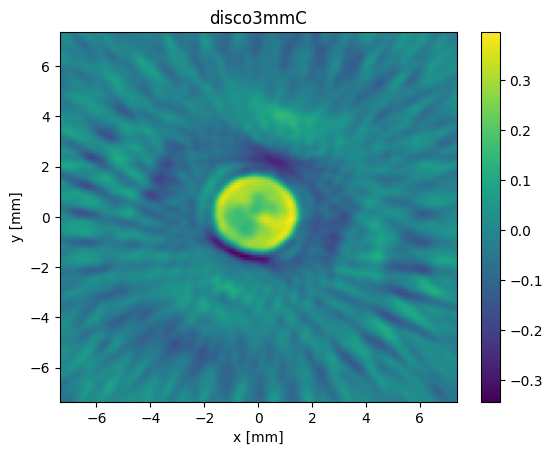

In [7]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.flip(np.reshape(Xdas,(nx,nx)),0),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

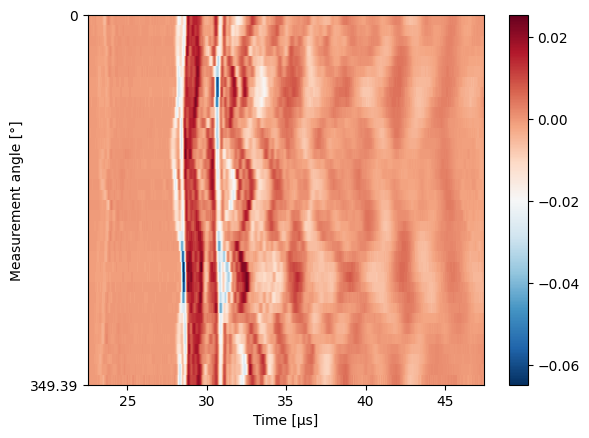

In [8]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

## Results: plastico: med17sep24_3 (T = 25 us) (Amp = Judson) (lente = -30mm) 36 angles 

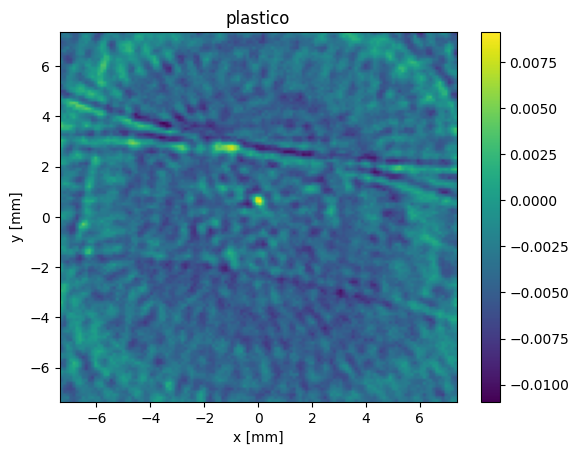

In [7]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.flip(np.reshape(Xdas,(nx,nx)),0),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

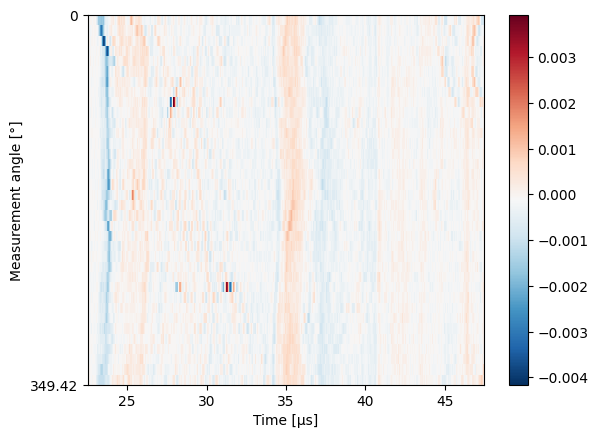

In [8]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

## Results: agarose: med17sep24_2 (T = 25 us) (Amp = Judson) (lente = -30mm) 36 angles 

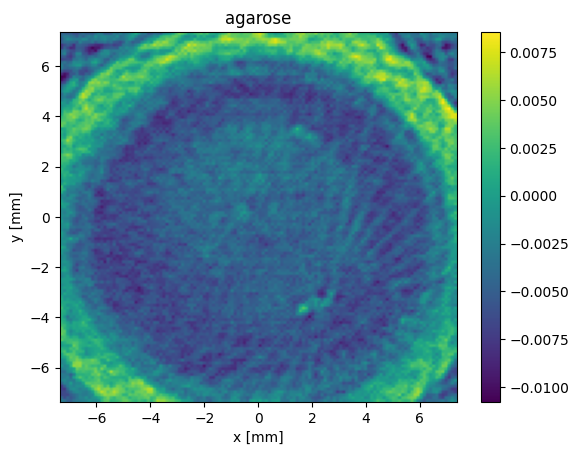

In [9]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.flip(np.reshape(Xdas,(nx,nx)),0),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

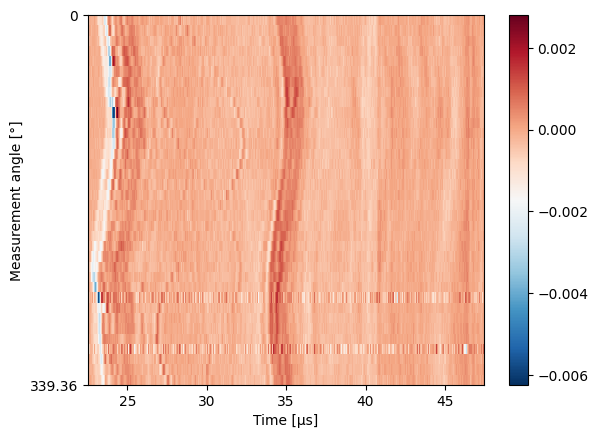

In [10]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

## Results: disco3mm: med17sep24_1 (T = 25 us) (Amp = Judson) (lente = -30mm) 36 angles 

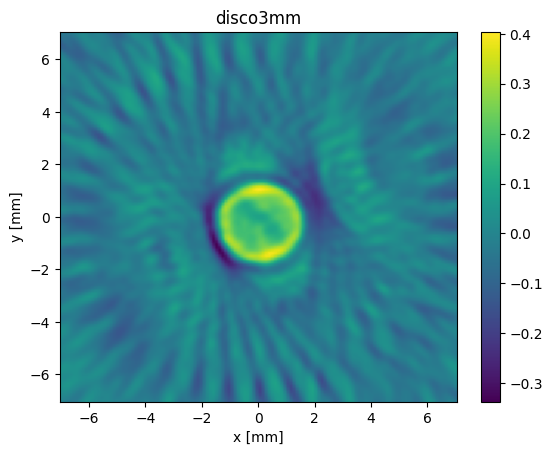

In [32]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.flip(np.reshape(Xdas,(nx,nx)),0),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

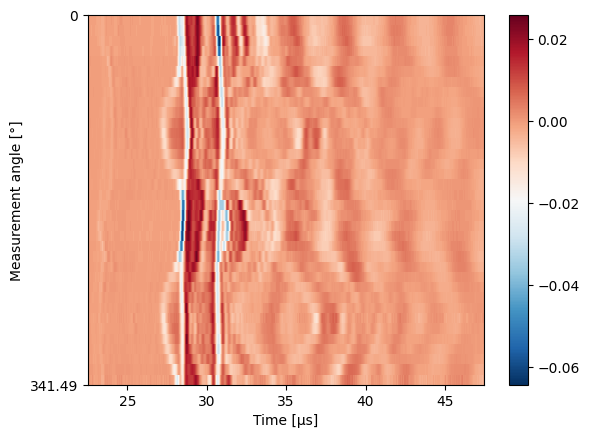

In [34]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [9]:
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)